In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import awkward as ak
import numpy as np
import boost_histogram as bh

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from coffea import processor, hist, util
from coffea.nanoevents.methods import candidate
import hist


import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
def delta_phi_alt(first, second):
    # my version, seems to be faster (and unsigned)
    return np.arccos(np.cos(first.phi - second.phi))

def delta_r2(first, second):
    return (first.eta - second.eta) ** 2 + delta_phi_alt(first, second) ** 2

def match(first, second, deltaRCut=0.4):
    drCut2 = deltaRCut**2
    combs = ak.cartesian([first, second], nested=True)
    return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)

In [4]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, deltaR):
        #dataset = events.metadata['dataset']

        
        mtd = ak.zip(
            {
                "eta": ak.concatenate((events['gp_eta_btl_hits'], events['gp_eta_etl_hits']), axis = 1),
                "phi": ak.concatenate((events['gp_phi_btl_hits'], events['gp_phi_etl_hits']), axis = 1),
                "times": ak.concatenate((events['gp_time_btl_hits'], events['gp_time_etl_hits']), axis = 1),
                "energy": ak.concatenate((events['gp_energy_btl_hits'], events['gp_energy_etl_hits']), axis=1),
                "x": ak.concatenate((events['gp_x_btl_hits'], events['gp_x_etl_hits']), axis=1),
                "y": ak.concatenate((events['gp_y_btl_hits'], events['gp_y_etl_hits']), axis=1),
                "z": ak.concatenate((events['gp_z_btl_hits'], events['gp_z_etl_hits']), axis=1),
                "theta": ak.concatenate((events['gp_theta_btl_hits'], events['gp_theta_etl_hits']), axis=1), 
                
            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        v = 29.9792458
        mtd["tof"] = ((abs(mtd.x**2+mtd.y**2+mtd.z**2)**0.5)/v)
        mtd["delays"] = mtd.times - mtd.tof
            
        ele_eta = events['e_eta']
        gen_ele = ak.zip(
            {
                "eta": ele_eta,
                "phi": events['e_phi'],        
                "pt": events['e_pt'],
                "delay": (ak.concatenate([events['e_ebdelay'][abs(ele_eta)<1.48],
                                                  events['e_hgdelay'][abs(ele_eta)>1.48]], axis = 1) *10**9),
                "ctau": events['e_ctau']/10,

            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        ele_eta_31_cut = abs(gen_ele.eta) < 3.1
        gen_ele = gen_ele[ele_eta_31_cut]

        reco_pho = ak.zip(
            {
                "eta": events['reco_photon_eta'],
                "phi": events['reco_photon_phi'], 
                "RH_time": events['reco_photon_MTDtime'], 

            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        matched_pho = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]
        matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=deltaR)]

        ewt = []
        mtd_times_ele_delay_req = []
        mtd_delay_ele_delay_req = []
        closest_delay = []
        closest2_delay = []
        ewt_edelay_diff = []
        for i in range(len(matched_mtd)): #loops through each event
            for j in range(len(matched_pho[i])): #loops through each photon
                weightedTimeCell = 0
                totalEmEnergyCell = 0
                if len(matched_mtd[i]) > 0:
                    ak.argsort((matched_mtd.eta[i]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i]-matched_pho.phi[i][j])**2)
                    if (matched_mtd.eta[i][0]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][0]-matched_pho.phi[i][j])**2 < deltaR**2:
                        closest_delay.append(matched_mtd.delays[i][0])
                        closest2_delay.append(matched_mtd.delays[i][0])
                    if len(matched_mtd[i]) > 1 and (matched_mtd.eta[i][1]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][1]-matched_pho.phi[i][j])**2 < deltaR**2:
                        closest2_delay.append(matched_mtd.delays[i][1])
                for k in range(len(matched_mtd[i])): #loops through each hit
                    deltar_diff = (matched_mtd.eta[i][k] - matched_pho.eta[i][j])**2 + (matched_mtd.phi[i][k] - matched_pho.phi[i][j])**2
                    if deltar_diff < deltaR**2:
                        weightedTimeCell += (matched_mtd.times[i][k]-matched_mtd.tof[i][k]) * matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                        totalEmEnergyCell += matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                        if matched_pho.delay[i][j] > 1: #in ns 
                            mtd_times_ele_delay_req.append(matched_mtd.times[i][k])
                            mtd_delay_ele_delay_req.append(matched_mtd.delays[i][k])         
                if totalEmEnergyCell==0:
                    ewt.append(-999)
                if totalEmEnergyCell!=0:
                    ewt.append(weightedTimeCell/totalEmEnergyCell)  
        ewt_edelay_diff = []
        for i in range(len(ewt)):
            if ewt[i]>-900:
                ewt_edelay_diff.append((ewt[i] - ak.flatten(matched_pho.delay)[i]))
                
                
        
        return {
            "entries": len(events),
            "tof": mtd.tof,
            "ewt": ewt,
            "ewt_diff": ewt_edelay_diff,
            #"RH": matched_pho.RH_time,
            "close": closest_delay,
            "close2": closest2_delay,
            "ele_delays": matched_pho.delay,
            "mtd_times": matched_mtd.times,
            "mtd_delays": matched_mtd.delays,
            "mtd_eta": matched_mtd.eta,
            "mtd_phi": matched_mtd.phi,
            "mtd_times_ele_delay_req": mtd_times_ele_delay_req,
            "mtd_delay_ele_delay_req": mtd_delay_ele_delay_req,
            "ele_distance": matched_pho.ctau,
        }
    

    def postprocess(self, accumulator):
        pass

In [5]:
events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_1000mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_pv_1000mm_10k.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

p = MyProcessor()

#out_2_1000 = p.process(events, deltaR=0.2)
#out_1_1000 = p.process(events, deltaR=0.1)
#out_05_1000 = p.process(events, deltaR=0.05)
out_03_1000_old = p.process(events, deltaR=0.03)
#out_01_1000 = p.process(events, deltaR=0.01)

events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_0mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_pv_0mm_10k.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

p = MyProcessor()

#out_2 = p.process(events, deltaR=0.2)
#out_1 = p.process(events, deltaR=0.1)
#out_05 = p.process(events, deltaR=0.05)
out_03_old = p.process(events, deltaR=0.03)
#out_01 = p.process(events, deltaR=0.01)

In [6]:
#####################THIS IS THE PV ATTEMPT
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, deltaR):
        #dataset = events.metadata['dataset']
        
        pv = ak.zip(
            {
                "times": events['pv_t'],
                "x": events['pv_x'],
                "y": events['pv_y'],
                "z": events['pv_z'],
            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        mtd = ak.zip(
            {
                "eta": ak.concatenate((events['gp_eta_btl_hits'], events['gp_eta_etl_hits']), axis = 1),
                "phi": ak.concatenate((events['gp_phi_btl_hits'], events['gp_phi_etl_hits']), axis = 1),
                "times_nopv": ak.concatenate((events['gp_time_btl_hits'], events['gp_time_etl_hits']), axis = 1),
                "energy": ak.concatenate((events['gp_energy_btl_hits'], events['gp_energy_etl_hits']), axis=1),
                "x": ak.concatenate((events['gp_x_btl_hits'], events['gp_x_etl_hits']), axis=1),
                "y": ak.concatenate((events['gp_y_btl_hits'], events['gp_y_etl_hits']), axis=1),
                "z": ak.concatenate((events['gp_z_btl_hits'], events['gp_z_etl_hits']), axis=1),
                "theta": ak.concatenate((events['gp_theta_btl_hits'], events['gp_theta_etl_hits']), axis=1), 
                
            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        v = 29.9792458
        hello = []
        bye = []
        for i in range(len(mtd)):
            hello.append((abs((mtd.x[i]-ak.Array([pv.x[i][0]]))**2+(mtd.y[i]-ak.Array([pv.y[i][0]]))**2
                      +(mtd.z[i]-ak.Array([pv.z[i][0]]))**2)**0.5)/v)
            bye.append(mtd.times_nopv[i]-ak.Array([pv.times[i][0]]))
        #mtd["tof"] = ((abs(mtd.x**2+mtd.y**2+mtd.z**2)**0.5)/v)
        mtd["times"] = bye
        mtd["tof"] = hello
        mtd["delays"] = mtd.times - mtd.tof 
            
        ele_eta = events['e_eta']
        gen_ele = ak.zip(
            {
                "eta": ele_eta,
                "phi": events['e_phi'],        
                "pt": events['e_pt'],
                "delay": (ak.concatenate([events['e_ebdelay'][abs(ele_eta)<1.48],
                                                  events['e_hgdelay'][abs(ele_eta)>1.48]], axis = 1) *10**9),
                "ctau": events['e_ctau']/10,

            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        ele_eta_31_cut = abs(gen_ele.eta) < 3.1
        gen_ele = gen_ele[ele_eta_31_cut]

        reco_pho = ak.zip(
            {
                "eta": events['reco_photon_eta'],
                "phi": events['reco_photon_phi'], 
                "RH_time": events['reco_photon_MTDtime'], 

            },
            #with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        matched_pho = gen_ele[match(gen_ele, reco_pho, deltaRCut=0.1)]
        matched_mtd = mtd[match(mtd, matched_pho, deltaRCut=deltaR)]

        ewt = []
        mtd_times_ele_delay_req = []
        mtd_delay_ele_delay_req = []
        closest_delay = []
        closest2_delay = []
        ewt_edelay_diff = []
        for i in range(len(matched_mtd)): #loops through each event
            for j in range(len(matched_pho[i])): #loops through each photon
                weightedTimeCell = 0
                totalEmEnergyCell = 0
                if len(matched_mtd[i]) > 0:
                    ak.argsort((matched_mtd.eta[i]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i]-matched_pho.phi[i][j])**2)
                    if (matched_mtd.eta[i][0]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][0]-matched_pho.phi[i][j])**2 < deltaR**2:
                        closest_delay.append(matched_mtd.delays[i][0])
                        closest2_delay.append(matched_mtd.delays[i][0])
                    if len(matched_mtd[i]) > 1 and (matched_mtd.eta[i][1]-matched_pho.eta[i][j])**2+(matched_mtd.phi[i][1]-matched_pho.phi[i][j])**2 < deltaR**2:
                        closest2_delay.append(matched_mtd.delays[i][1])
                for k in range(len(matched_mtd[i])): #loops through each hit
                    deltar_diff = (matched_mtd.eta[i][k] - matched_pho.eta[i][j])**2 + (matched_mtd.phi[i][k] - matched_pho.phi[i][j])**2
                    if deltar_diff < deltaR**2:
                        weightedTimeCell += (matched_mtd.times[i][k]-matched_mtd.tof[i][k]) * matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                        totalEmEnergyCell += matched_mtd.energy[i][k] * np.sin(matched_mtd.theta[i][k])
                        if matched_pho.delay[i][j] > 1: #in ns 
                            mtd_times_ele_delay_req.append(matched_mtd.times[i][k])
                            mtd_delay_ele_delay_req.append(matched_mtd.delays[i][k])         
                if totalEmEnergyCell==0:
                    ewt.append(-999)
                if totalEmEnergyCell!=0:
                    ewt.append(weightedTimeCell/totalEmEnergyCell)  
        ewt_edelay_diff = []
        for i in range(len(ewt)):
            if ewt[i]>-900:
                ewt_edelay_diff.append((ewt[i] - ak.flatten(matched_pho.delay)[i]))
                
                
        
        return {
            "entries": len(events),
            "tof": mtd.tof,
            "ewt": ewt,
            "ewt_diff": ewt_edelay_diff,
            #"RH": matched_pho.RH_time,
            "close": closest_delay,
            "close2": closest2_delay,
            "ele_delays": matched_pho.delay,
            "mtd_times": matched_mtd.times,
            "mtd_delays": matched_mtd.delays,
            "mtd_eta": matched_mtd.eta,
            "mtd_phi": matched_mtd.phi,
            "mtd_times_ele_delay_req": mtd_times_ele_delay_req,
            "mtd_delay_ele_delay_req": mtd_delay_ele_delay_req,
            "ele_distance": matched_pho.ctau,
        }
    

    def postprocess(self, accumulator):
        pass

In [10]:
events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_0mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_pv_0mm_10k.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

p = MyProcessor()

out_2 = p.process(events, deltaR=0.2)
out_1 = p.process(events, deltaR=0.1)
out_05 = p.process(events, deltaR=0.05)
out_03 = p.process(events, deltaR=0.03)
out_01 = p.process(events, deltaR=0.01)

In [11]:
events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_1000mm.root',
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_pv_1000mm_10k.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

p = MyProcessor()

out_2_1000 = p.process(events, deltaR=0.2)
out_1_1000 = p.process(events, deltaR=0.1)
out_05_1000 = p.process(events, deltaR=0.05)
out_03_1000 = p.process(events, deltaR=0.03)
out_01_1000 = p.process(events, deltaR=0.01)

In [ ]:
events = NanoEventsFactory.from_root(
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/test_100mm.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

p = MyProcessor()

out_1_100 = p.process(events, deltaR=0.1)
out_03_100 = p.process(events, deltaR=0.03)

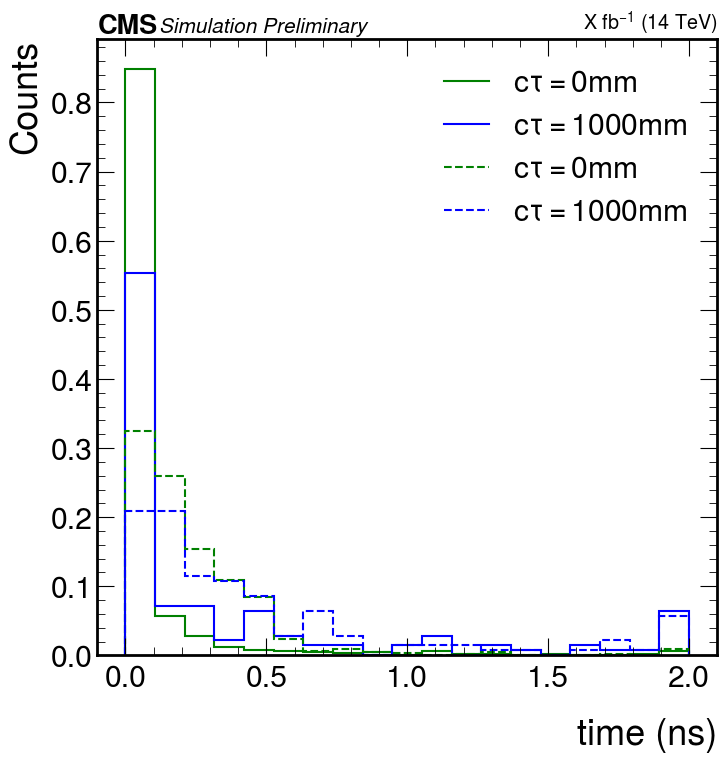

In [12]:
#plots the ewt (not the difference) of the photons
ewt_0 = ak.Array(out_03['ewt'])
ewt_1000 = ak.Array(out_03_1000['ewt_diff'])
#ewt_100 = ak.Array(out_03_100['ewt_diff'])
ewt_0_old = ak.Array(out_03_old['ewt'])
ewt_1000_old = ak.Array(out_03_1000_old['ewt_diff'])


ewt_0 = ewt_0[ewt_0>-900]
ewt_1000 = ewt_1000[ewt_1000>-900]
#ewt_100 = ewt_100[ewt_100>-900]
ewt_0_old = ewt_0_old[ewt_0_old>-900]
ewt_1000_old = ewt_1000_old[ewt_1000_old>-900]

time_bins = np.linspace(0, 2, 20)

ewt_0_hist = np.histogram(np.clip(abs(ewt_0), time_bins[0], time_bins[-1]), bins=time_bins)
#ewt_100_hist = np.histogram(np.clip(abs(ewt_100), time_bins[0], time_bins[-1]), bins=time_bins)
ewt_1000_hist = np.histogram(np.clip(abs(ewt_1000), time_bins[0], time_bins[-1]), bins=time_bins)

ewt_0_hist_old = np.histogram(np.clip(abs(ewt_0_old), time_bins[0], time_bins[-1]), bins=time_bins)
#ewt_100_hist = np.histogram(np.clip(abs(ewt_100), time_bins[0], time_bins[-1]), bins=time_bins)
ewt_1000_hist_old = np.histogram(np.clip(abs(ewt_1000_old), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

norm = ak.sum(ewt_0_hist[0])

hep.histplot(
    ewt_0_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 0mm$'],
    color=['green'],
    ax=ax,
    )

'''norm = ak.sum(ewt_100_hist[0])
hep.histplot(
    ewt_100_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 100mm$'],
    color=['red'],
    ax=ax,
    )'''

norm = ak.sum(ewt_1000_hist[0])
hep.histplot(
    ewt_1000_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 1000mm$'],
    color=['blue'],
    ax=ax,
    )

norm = ak.sum(ewt_0_hist_old[0])
hep.histplot(
    ewt_0_hist_old[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 0mm$'],
    color=['green'],
    linestyle = 'dashed',
    ax=ax,
    )

norm = ak.sum(ewt_1000_hist_old[0])
hep.histplot(
    ewt_1000_hist_old[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 1000mm$'],
    color=['blue'],
    linestyle = 'dashed',
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/ewt_deltar03.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/PV_ewt_deltar03.png')

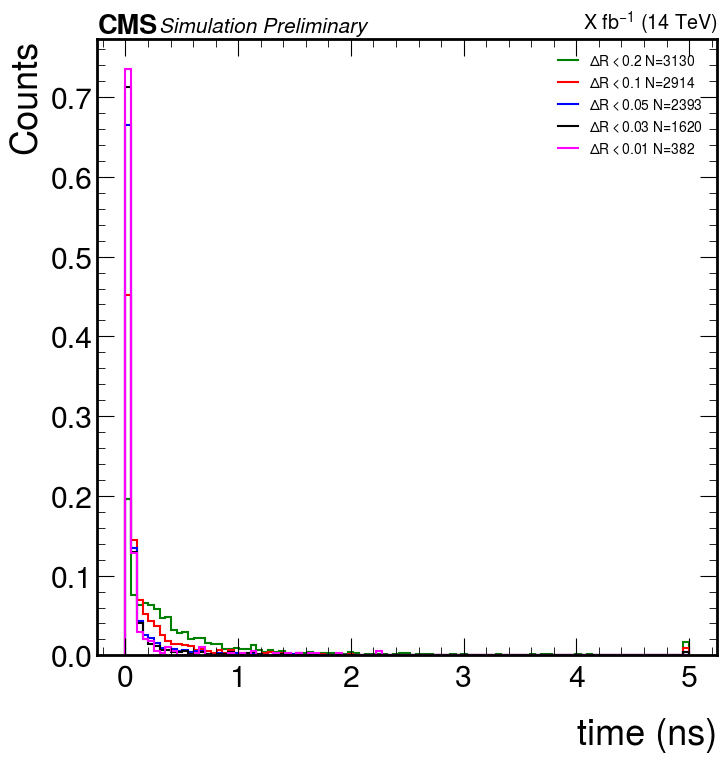

In [27]:
ewtr2 = ak.Array(np.absolute(out_2['ewt_diff']))
ewtr1 = ak.Array(np.absolute(out_1['ewt_diff']))
ewtr05 = ak.Array(np.absolute(out_05['ewt_diff']))
ewtr03 = ak.Array(np.absolute(out_03['ewt_diff']))
ewtr01 = ak.Array(np.absolute(out_01['ewt_diff']))

time_bins = np.linspace(0, 5, 100)
#time_bins = np.linspace(-2, 5, 100)

ewtr2_delay_diff_hist = np.histogram(np.clip((ewtr2), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr1_delay_diff_hist = np.histogram(np.clip((ewtr1), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr05_delay_diff_hist = np.histogram(np.clip((ewtr05), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr03_delay_diff_hist = np.histogram(np.clip((ewtr03), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr01_delay_diff_hist = np.histogram(np.clip((ewtr01), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

norm = ak.sum(ewtr2_delay_diff_hist[0])
hep.histplot(
    ewtr2_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.2$ N=%s' %(round(norm,2))],
    color=['green'],
    ax=ax,
    )

norm = ak.sum(ewtr1_delay_diff_hist[0])
mid = len(ewtr1)//2
mid_val = ak.sort(ewtr1)[mid]
minus_1sig = np.int_(len(ewtr1)*0.16)
plus_1sig = np.int_(len(ewtr1)*0.84)
mean_width = ak.sort(ewtr1)[plus_1sig] - ak.sort(ewtr1)[minus_1sig]
hep.histplot(
    ewtr1_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.1$ N=%s' %(round(norm,2))],
    color=['red'],
    ax=ax,
    )

norm = ak.sum(ewtr05_delay_diff_hist[0])
hep.histplot(
    ewtr05_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.05$ N=%s' %(round(norm,2))],
    color=['blue'],
    ax=ax,
    )

norm = ak.sum(ewtr03_delay_diff_hist[0])
hep.histplot(
    ewtr03_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.03$ N=%s' %(round(norm,2))],
    color=['k'],
    ax=ax,
    )

norm = ak.sum(ewtr01_delay_diff_hist[0])
hep.histplot(
    ewtr01_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.01$ N=%s' %(round(norm,2))],
    color=['magenta'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend(prop={'size': 10})

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/pv_diff_ewt_edelay_ctau0_norm.png')

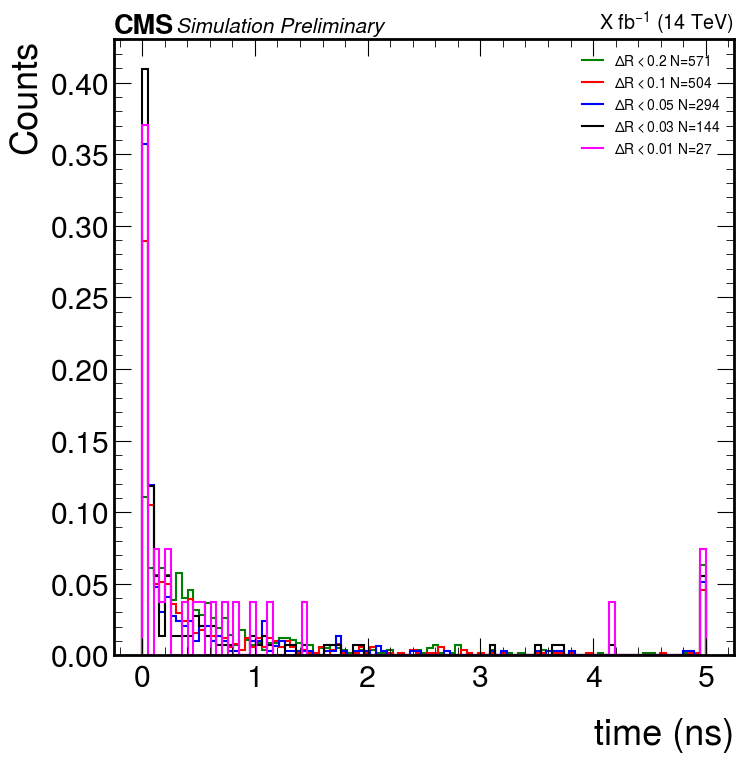

In [25]:
ewtr2 = ak.Array(np.absolute(out_2_1000['ewt_diff']))
ewtr1 = ak.Array(np.absolute(out_1_1000['ewt_diff']))
ewtr05 = ak.Array(np.absolute(out_05_1000['ewt_diff']))
ewtr03 = ak.Array(np.absolute(out_03_1000['ewt_diff']))
ewtr01 = ak.Array(np.absolute(out_01_1000['ewt_diff']))

time_bins = np.linspace(0, 5, 100)
#time_bins = np.linspace(-5, 5, 100)

ewtr2_delay_diff_hist = np.histogram(np.clip((ewtr2), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr1_delay_diff_hist = np.histogram(np.clip((ewtr1), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr05_delay_diff_hist = np.histogram(np.clip((ewtr05), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr03_delay_diff_hist = np.histogram(np.clip((ewtr03), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr01_delay_diff_hist = np.histogram(np.clip((ewtr01), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

norm = ak.sum(ewtr2_delay_diff_hist[0])
hep.histplot(
    ewtr2_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.2$ N=%s' %(round(norm,2))],
    color=['green'],
    ax=ax,
    )

norm = ak.sum(ewtr1_delay_diff_hist[0])
hep.histplot(
    ewtr1_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.1$ N=%s' %(round(norm,2))],
    color=['red'],
    ax=ax,
    )

norm = ak.sum(ewtr05_delay_diff_hist[0])
hep.histplot(
    ewtr05_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.05$ N=%s' %(round(norm,2))],
    color=['blue'],
    ax=ax,
    )

norm = ak.sum(ewtr03_delay_diff_hist[0])
hep.histplot(
    ewtr03_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.03$ N=%s' %(round(norm,2))],
    color=['k'],
    ax=ax,
    )

norm = ak.sum(ewtr01_delay_diff_hist[0])
hep.histplot(
    ewtr01_delay_diff_hist[0]/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.01$ N=%s' %(round(norm,2))],
    color=['magenta'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend(prop={'size': 10})

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/pv_diff_ewt_edelay_ctau1000_norm.png')

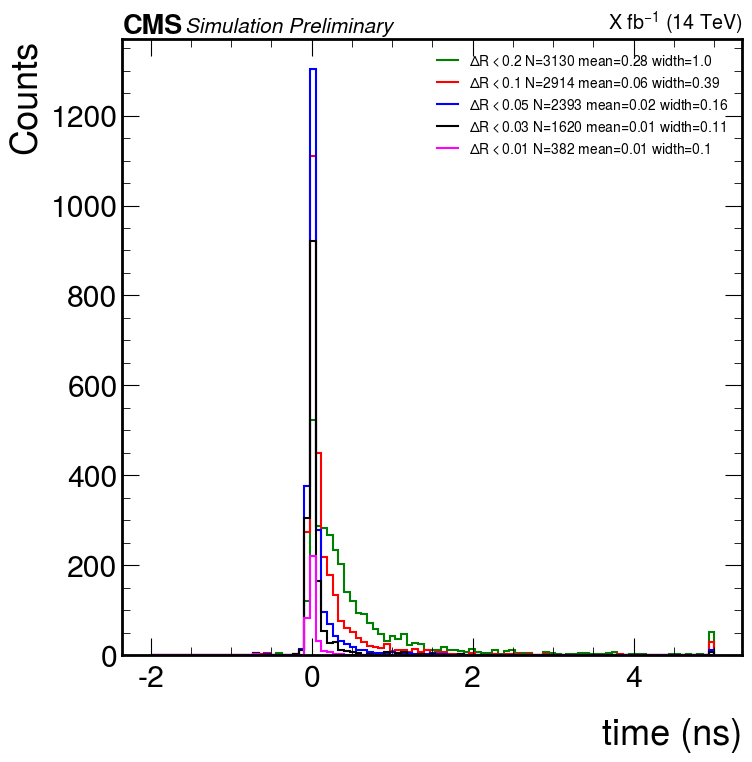

In [17]:
ewtr2 = ak.Array(out_2['ewt_diff'])
ewtr1 = ak.Array(out_1['ewt_diff'])
ewtr05 = ak.Array(out_05['ewt_diff'])
ewtr03 = ak.Array(out_03['ewt_diff'])
ewtr01 = ak.Array(out_01['ewt_diff'])

#time_bins = np.linspace(0, 5, 100)
time_bins = np.linspace(-2, 5, 100)

ewtr2_delay_diff_hist = np.histogram(np.clip((ewtr2), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr1_delay_diff_hist = np.histogram(np.clip((ewtr1), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr05_delay_diff_hist = np.histogram(np.clip((ewtr05), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr03_delay_diff_hist = np.histogram(np.clip((ewtr03), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr01_delay_diff_hist = np.histogram(np.clip((ewtr01), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

norm = ak.sum(ewtr2_delay_diff_hist[0])
mid = len(ewtr2)//2
mid_val = ak.sort(ewtr2)[mid]
minus_1sig = np.int_(len(ewtr2)*0.16)
plus_1sig = np.int_(len(ewtr2)*0.84)
mean_width = ak.sort(ewtr2)[plus_1sig] - ak.sort(ewtr2)[minus_1sig]
hep.histplot(
    ewtr2_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.2$ N=%s mean=%s width=%s ' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['green'],
    ax=ax,
    )

norm = ak.sum(ewtr1_delay_diff_hist[0])
mid = len(ewtr1)//2
mid_val = ak.sort(ewtr1)[mid]
minus_1sig = np.int_(len(ewtr1)*0.16)
plus_1sig = np.int_(len(ewtr1)*0.84)
mean_width = ak.sort(ewtr1)[plus_1sig] - ak.sort(ewtr1)[minus_1sig]
hep.histplot(
    ewtr1_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.1$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['red'],
    ax=ax,
    )

norm = ak.sum(ewtr05_delay_diff_hist[0])
mid = len(ewtr05)//2
mid_val = ak.sort(ewtr05)[mid]
minus_1sig = np.int_(len(ewtr05)*0.16)
plus_1sig = np.int_(len(ewtr05)*0.84)
mean_width = ak.sort(ewtr05)[plus_1sig] - ak.sort(ewtr05)[minus_1sig]
hep.histplot(
    ewtr05_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.05$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['blue'],
    ax=ax,
    )

norm = ak.sum(ewtr03_delay_diff_hist[0])
mid = len(ewtr03)//2
mid_val = ak.sort(ewtr03)[mid]
minus_1sig = np.int_(len(ewtr03)*0.16)
plus_1sig = np.int_(len(ewtr03)*0.84)
mean_width = ak.sort(ewtr03)[plus_1sig] - ak.sort(ewtr03)[minus_1sig]
hep.histplot(
    ewtr03_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.03$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['k'],
    ax=ax,
    )

norm = ak.sum(ewtr01_delay_diff_hist[0])
mid = len(ewtr01)//2
mid_val = ak.sort(ewtr01)[mid]
minus_1sig = np.int_(len(ewtr01)*0.16)
plus_1sig = np.int_(len(ewtr01)*0.84)
mean_width = ak.sort(ewtr01)[plus_1sig] - ak.sort(ewtr01)[minus_1sig]
hep.histplot(
    ewtr01_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.01$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['magenta'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend(prop={'size': 10})

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/pv_diff_ewt_edelay_ctau0_notabs_v2.png')

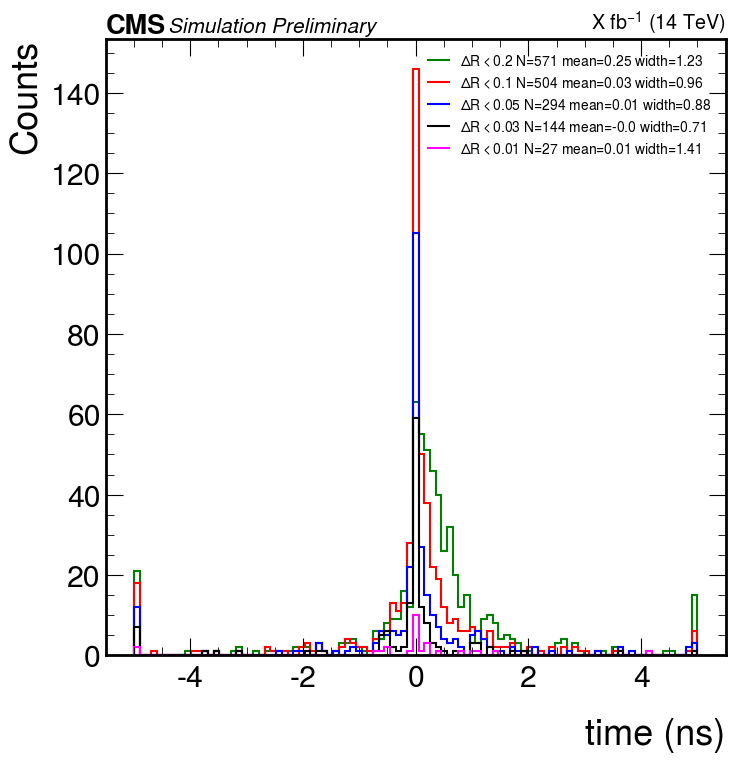

In [16]:
ewtr2 = ak.Array(out_2_1000['ewt_diff'])
ewtr1 = ak.Array(out_1_1000['ewt_diff'])
ewtr05 = ak.Array(out_05_1000['ewt_diff'])
ewtr03 = ak.Array(out_03_1000['ewt_diff'])
ewtr01 = ak.Array(out_01_1000['ewt_diff'])

#time_bins = np.linspace(0, 5, 100)
time_bins = np.linspace(-5, 5, 100)

ewtr2_delay_diff_hist = np.histogram(np.clip((ewtr2), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr1_delay_diff_hist = np.histogram(np.clip((ewtr1), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr05_delay_diff_hist = np.histogram(np.clip((ewtr05), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr03_delay_diff_hist = np.histogram(np.clip((ewtr03), time_bins[0], time_bins[-1]), bins=time_bins)
ewtr01_delay_diff_hist = np.histogram(np.clip((ewtr01), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

norm = ak.sum(ewtr2_delay_diff_hist[0])
mid = len(ewtr2)//2
mid_val = ak.sort(ewtr2)[mid]
minus_1sig = np.int_(len(ewtr2)*0.16)
plus_1sig = np.int_(len(ewtr2)*0.84)
mean_width = ak.sort(ewtr2)[plus_1sig] - ak.sort(ewtr2)[minus_1sig]
hep.histplot(
    ewtr2_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.2$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['green'],
    ax=ax,
    )

norm = ak.sum(ewtr1_delay_diff_hist[0])
mid = len(ewtr1)//2
mid_val = ak.sort(ewtr1)[mid]
minus_1sig = np.int_(len(ewtr1)*0.16)
plus_1sig = np.int_(len(ewtr1)*0.84)
mean_width = ak.sort(ewtr1)[plus_1sig] - ak.sort(ewtr1)[minus_1sig]
hep.histplot(
    ewtr1_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.1$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['red'],
    ax=ax,
    )

norm = ak.sum(ewtr05_delay_diff_hist[0])
mid = len(ewtr05)//2
mid_val = ak.sort(ewtr05)[mid]
minus_1sig = np.int_(len(ewtr05)*0.16)
plus_1sig = np.int_(len(ewtr05)*0.84)
mean_width = ak.sort(ewtr05)[plus_1sig] - ak.sort(ewtr05)[minus_1sig]
hep.histplot(
    ewtr05_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.05$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['blue'],
    ax=ax,
    )

norm = ak.sum(ewtr03_delay_diff_hist[0])
mid = len(ewtr03)//2
mid_val = ak.sort(ewtr03)[mid]
minus_1sig = np.int_(len(ewtr03)*0.16)
plus_1sig = np.int_(len(ewtr03)*0.84)
mean_width = ak.sort(ewtr03)[plus_1sig] - ak.sort(ewtr03)[minus_1sig]
hep.histplot(
    ewtr03_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.03$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['k'],
    ax=ax,
    )

norm = ak.sum(ewtr01_delay_diff_hist[0])
mid = len(ewtr01)//2
mid_val = ak.sort(ewtr01)[mid]
minus_1sig = np.int_(len(ewtr01)*0.16)
plus_1sig = np.int_(len(ewtr01)*0.84)
mean_width = ak.sort(ewtr01)[plus_1sig] - ak.sort(ewtr01)[minus_1sig]
hep.histplot(
    ewtr01_delay_diff_hist[0],#/norm,
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$\Delta R<0.01$ N=%s mean=%s width=%s' %(round(norm,2), round(mid_val,2), round(mean_width,2))],
    color=['magenta'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend(prop={'size': 10})

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/pv_diff_ewt_edelay_ctau1000_notabs_v2.png')

In [ ]:
closest_hit = out_1['close']
closest_hit_1000 = out_1_1000['close']

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest_hit, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest_hit_1000, time_bins[0], time_bins[-1]), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/MTD_matches_delays_closest1_norm.png')

In [ ]:
closest2_hit = ak.concatenate((out_1['close'], out_1['close2']), axis = 0)
closest2_hits_1000 = ak.concatenate((out_1_1000['close'], out_1_1000['close2']), axis = 0)


time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest2_hit, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest2_hits_1000, time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/MTD_matches_delays_closest2_norm.png')

In [ ]:
#plots the distance for the electrons
ele_delay_times_0 = out_1['ele_distance'] 
ele_delay_times_1000 = out_1_1000['ele_distance'] 
ele_delay_times_100 = out_1_100['ele_distance'] 

time_bins = np.linspace(0, 200, 20)

ctau0_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_0), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_1000), time_bins[0], time_bins[-1]), bins=time_bins)
ctau100_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_100), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_hgeb_hist[0]/(ak.sum(ctau0_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 0mm$'],
    color=['blue'],
    ax=ax,
    )


hep.histplot(
    ctau100_hgeb_hist[0]/(ak.sum(ctau100_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 100mm$'],
    color=['green'],
    ax=ax,
    )

hep.histplot(
    ctau1000_hgeb_hist[0]/(ak.sum(ctau1000_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 1000mm$'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('distance (cm)')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/displacement_norm.png')

In [ ]:
#plots the time delays for eb and hg
ele_delay_times_0 = out_1['ele_delays'] 
ele_delay_times_1000 = out_1_1000['ele_delays'] 
ele_delay_times_100 = out_1_100['ele_delays'] 

time_bins = np.linspace(0, 2, 20)

ctau0_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_0), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_1000), time_bins[0], time_bins[-1]), bins=time_bins)
ctau100_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_100), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_hgeb_hist[0]/(ak.sum(ctau0_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 0mm$'],
    color=['blue'],
    ax=ax,
    )


hep.histplot(
    ctau100_hgeb_hist[0]/(ak.sum(ctau100_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 100mm$'],
    color=['green'],
    ax=ax,
    )

hep.histplot(
    ctau1000_hgeb_hist[0]/(ak.sum(ctau1000_hgeb_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=[r'$c\tau = 1000mm$'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/hg_eb_delays_norm.png')

In [ ]:
#plots times for mtd hits that overlap with photon/ele 

mtd_matches_time_0 = out_1['mtd_times']
mtd_matches_time = out_1_1000['mtd_times']
time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip((ak.flatten(mtd_matches_time_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip((ak.flatten(mtd_matches_time)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/MTD_times_norm.png')

In [ ]:
#plots times for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

mtd_matches_time_1ns_0 = out_1['mtd_times_ele_delay_req']
mtd_matches_time_1ns = out_1_1000['mtd_times_ele_delay_req']

#plots times for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip(((mtd_matches_time_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(((mtd_matches_time_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/MTD_times_wdelay>1ns_norm.png')

In [ ]:
#plots delays for mtd hits that overlap with photon/ele 
mtd_matches_delays_0 = out_1['mtd_delays']
mtd_matches_delays = out_1_1000['mtd_delays']

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip((ak.flatten(mtd_matches_delays_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip((ak.flatten(mtd_matches_delays)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_deltar1.png')

In [ ]:
#plots delays for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

mtd_matches_delays_1ns_0 = out_1['mtd_delay_ele_delay_req']
mtd_matches_delays_1ns = out_1_1000['mtd_delay_ele_delay_req']

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(((mtd_matches_delays_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(((mtd_matches_delays_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/coffea_proc_attempt_v2/MTD_matches_delays_norm.png')